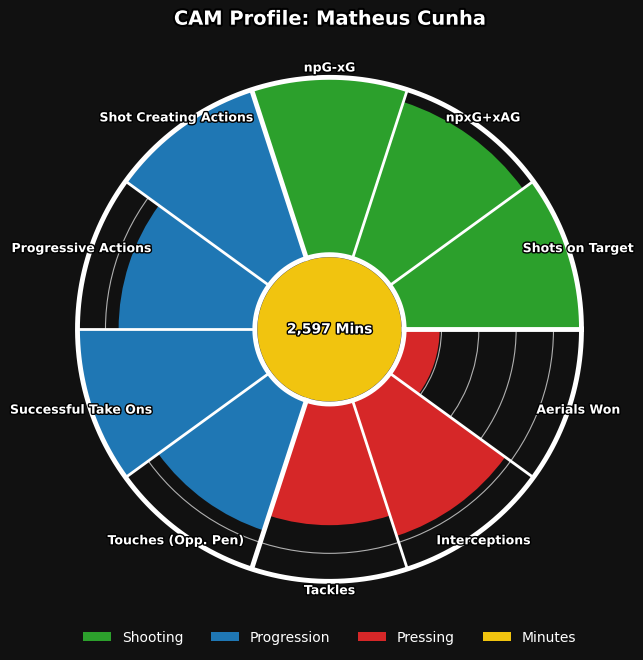

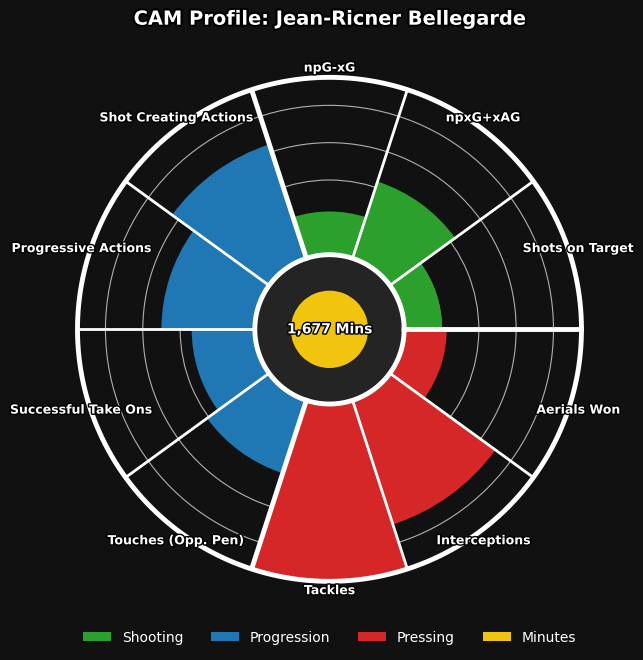

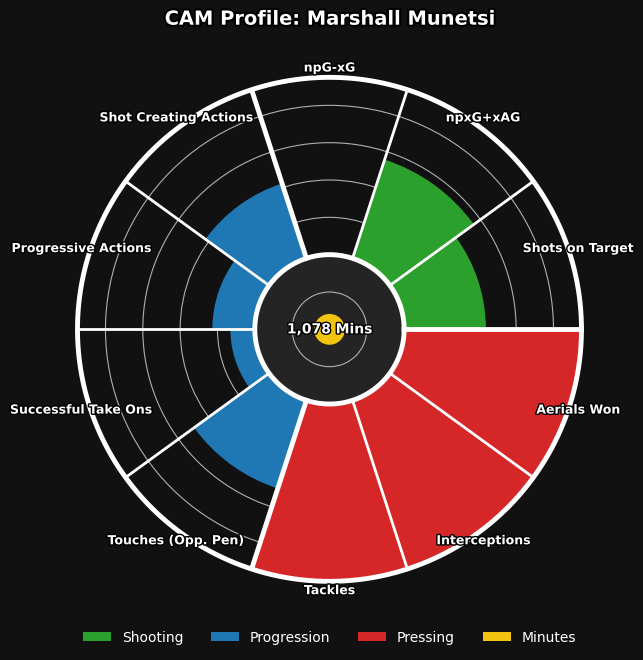

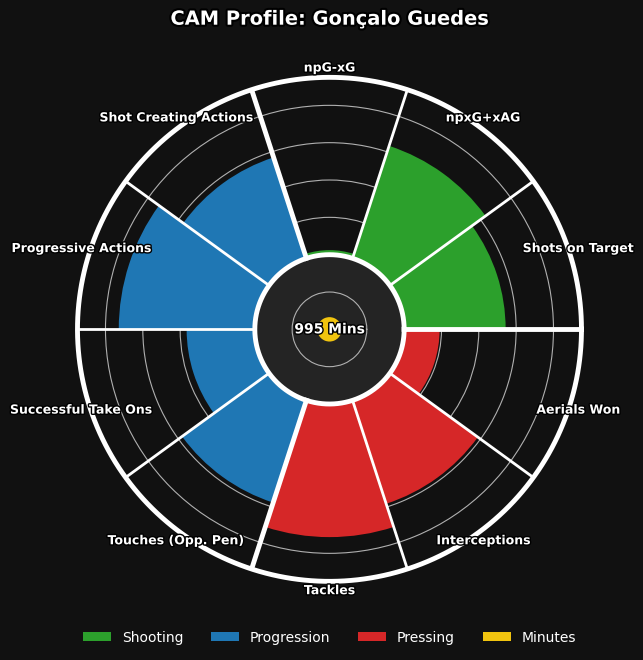

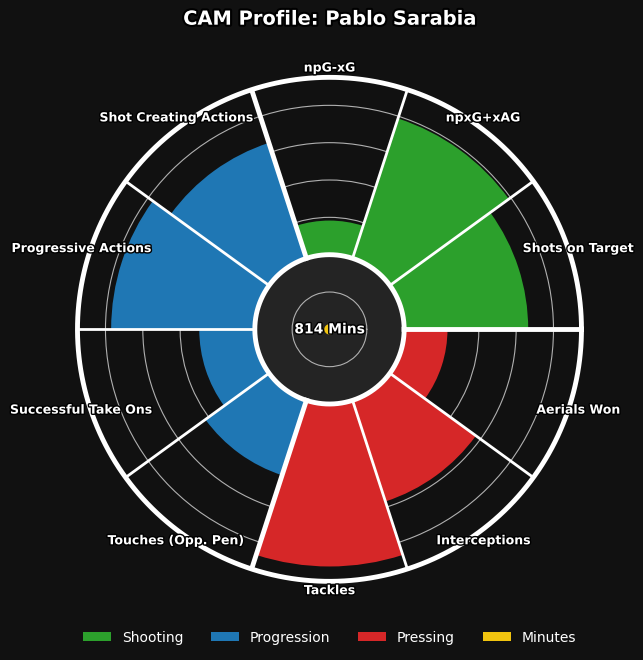

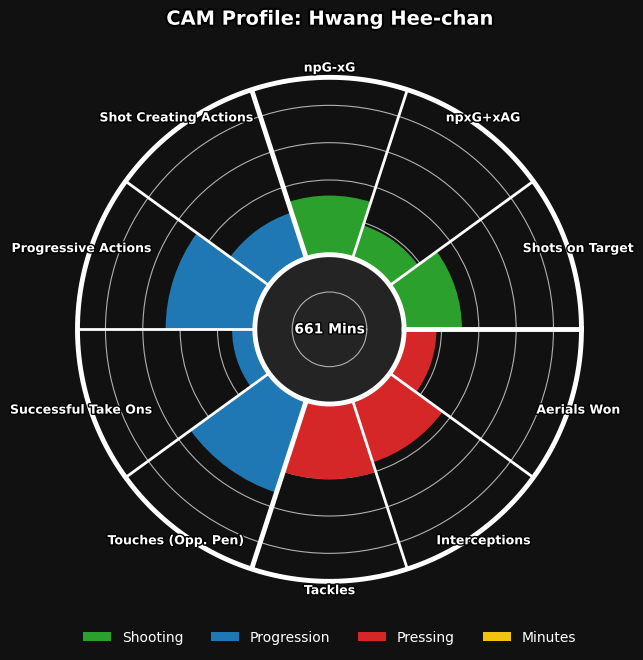

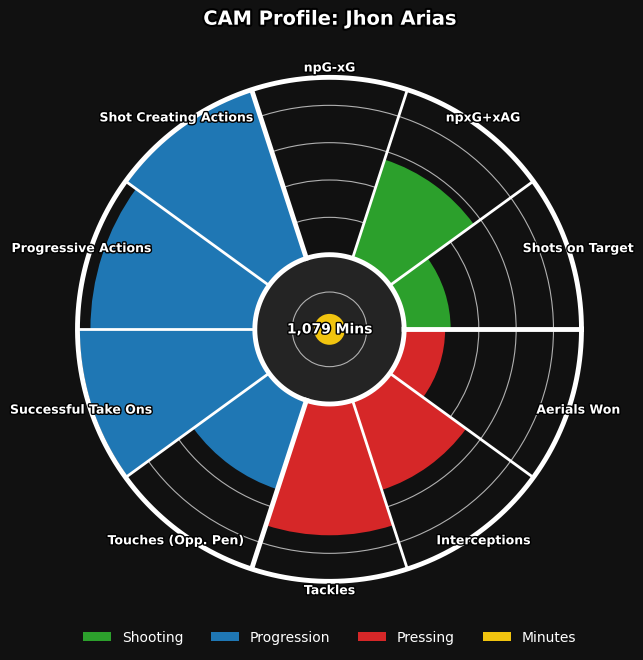

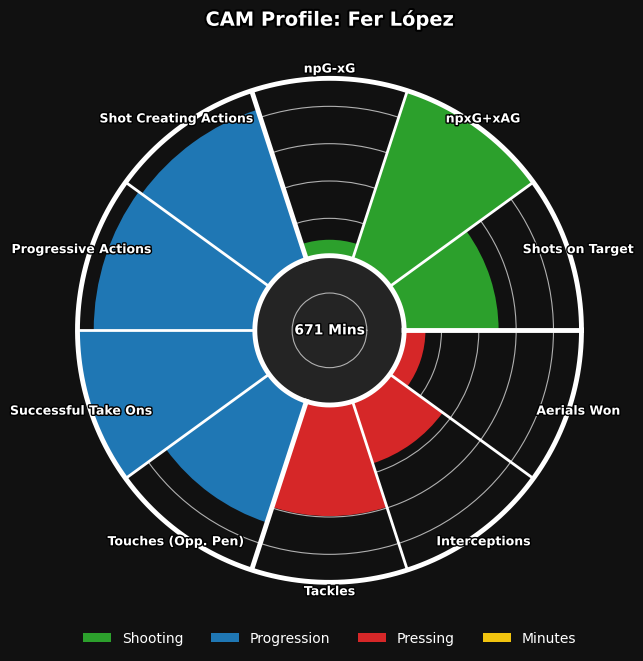

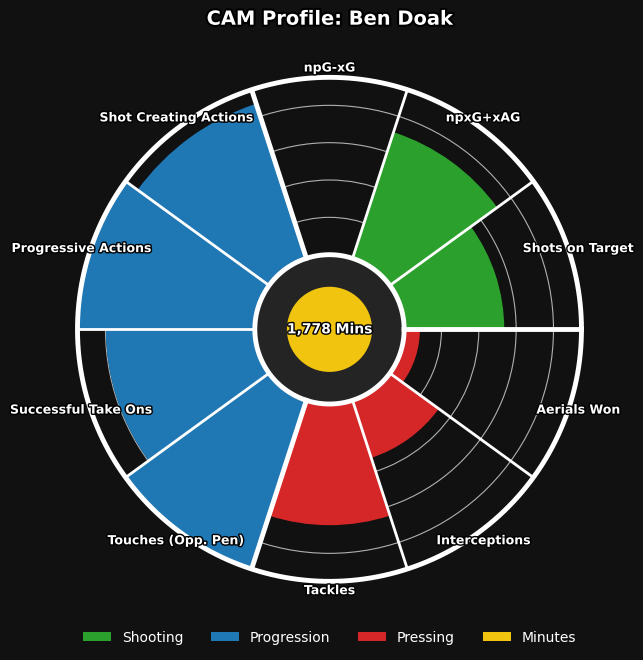

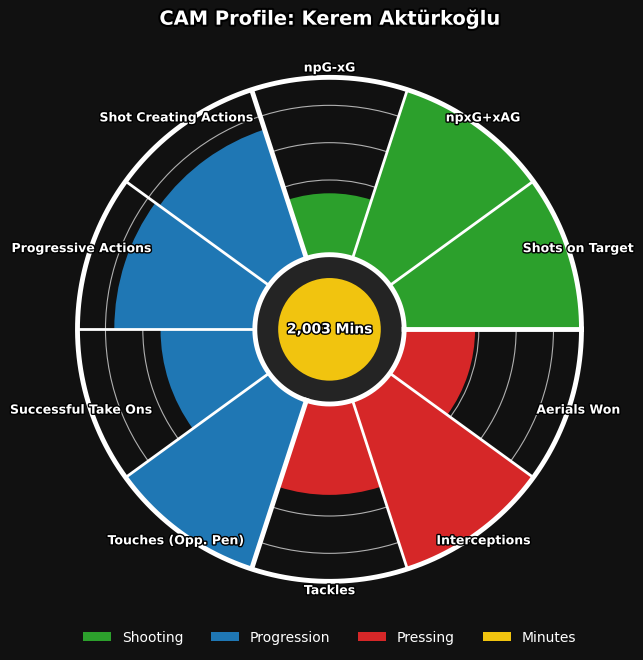

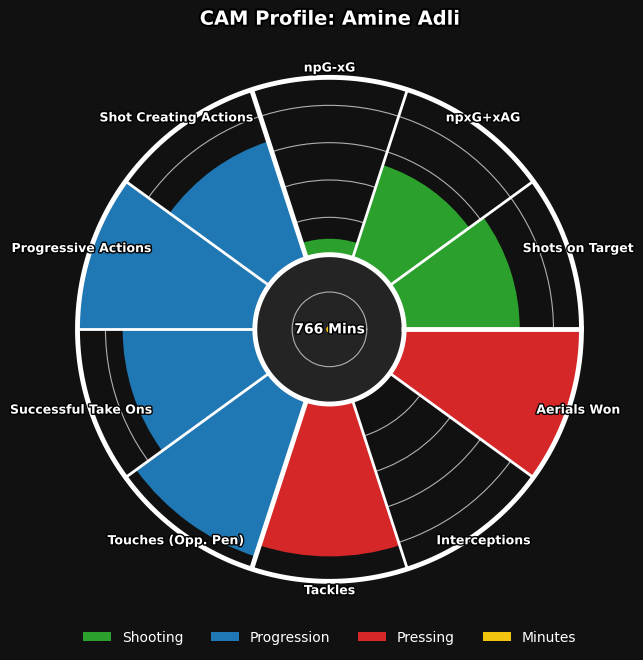

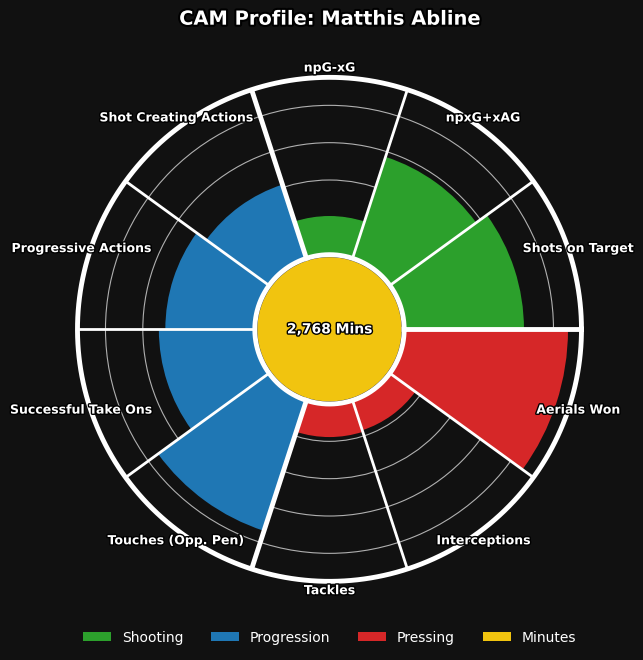

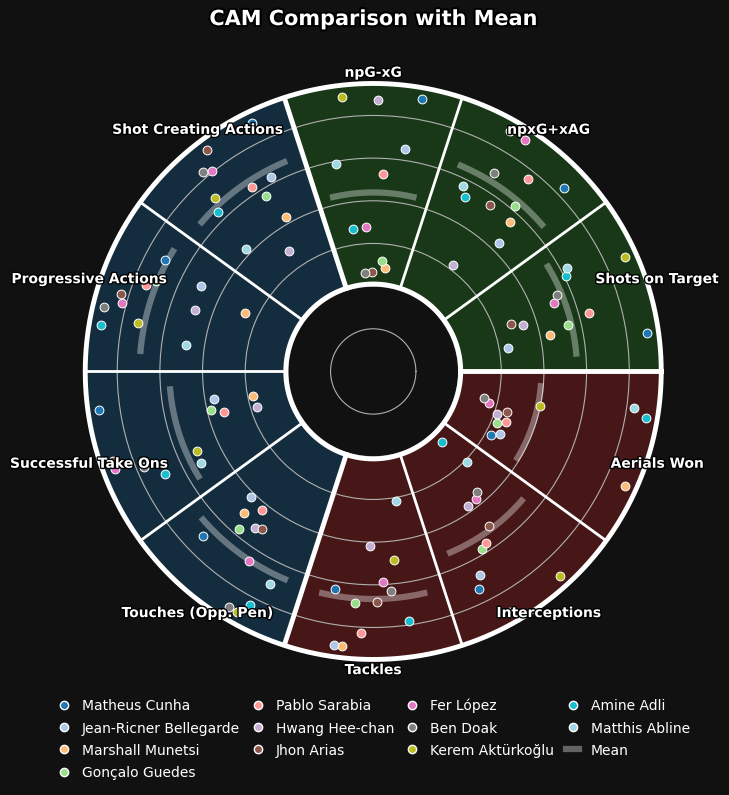

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from pathlib import Path

FILE = "wolves_standard_stats_scouted.xlsx"
df = pd.read_excel(FILE)

metrics = [
    'SOT90','npxG+xAG90','npG-xG90',
    'SCA90','PrgA90','STO90','TAP90',
    'Tackles90','Int90','AW90'
]

display_names = {
    'SOT90': 'Shots on Target',
    'npxG+xAG90': 'npxG+xAG',
    'npG-xG90': 'npG-xG',
    'SCA90': 'Shot Creating Actions',
    'PrgA90': 'Progressive Actions',
    'STO90': 'Successful Take Ons',
    'TAP90': 'Touches (Opp. Pen)',
    'Tackles90': 'Tackles',
    'Int90': 'Interceptions',
    'AW90': 'Aerials Won'
}

shooting   = ['SOT90','npxG+xAG90','npG-xG90']
progress   = ['SCA90','PrgA90','STO90','TAP90']
pressing   = ['Tackles90','Int90','AW90']
category_order = shooting + progress + pressing

FIG_BG = AX_BG = "#111111"
SHOOT_COLOR = "#2ca02c"
PROG_COLOR  = "#1f77b4"
PRESS_COLOR = "#d62728"

SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.5

MIN_BG_COLOR  = "#242424"
MIN_FILL_COLOR = "#f1c40f"
MIN_TEXT_COLOR = "white"

cam_df = df[df["Position"] == "CAM"].copy()
players = [str(p).strip() for p in cam_df["Player"].tolist()]

# --- normalization ---
nonneg_metrics = [m for m in metrics if m != 'npG-xG90']
p90 = df[nonneg_metrics].quantile(0.90)

# PLAYER donuts: full-range min–max for signed metric
npGx_min_all = df['npG-xG90'].min()
npGx_max_all = df['npG-xG90'].max()
npGx_rng_all = max(1e-9, npGx_max_all - npGx_min_all)

norm_df_player = cam_df.copy()
for m in nonneg_metrics:
    norm_df_player[m] = (cam_df[m] / p90[m]).clip(0.0, 1.0)
norm_df_player['npG-xG90'] = ((cam_df['npG-xG90'] - npGx_min_all) / npGx_rng_all).clip(0.0, 1.0)

# GROUP donut: robust 10–90 scaling for signed metric
npGx_lo = df['npG-xG90'].quantile(0.10)
npGx_hi = df['npG-xG90'].quantile(0.90)
npGx_rng = max(1e-9, npGx_hi - npGx_lo)

norm_df_group = cam_df.copy()
for m in nonneg_metrics:
    norm_df_group[m] = (cam_df[m] / p90[m]).clip(0.0, 1.0)
norm_df_group['npG-xG90'] = ((cam_df['npG-xG90'] - npGx_lo) / npGx_rng).clip(0.0, 1.0)

# minutes scaling
mins_series = cam_df['Min'].astype(float)
min_lo = np.nanpercentile(mins_series, 10) if len(mins_series) else 0.0
min_hi = np.nanpercentile(mins_series, 90) if len(mins_series) else 1.0
min_rng = max(1e-9, (min_hi - min_lo))

def minutes_fill_fraction(player_name):
    row = cam_df.loc[cam_df['Player'] == player_name, 'Min']
    if row.empty or pd.isna(row.iloc[0]):
        return 0.0, "Mins Unavailable"
    mins = float(row.iloc[0])
    frac = (mins - min_lo) / min_rng
    frac = float(np.clip(frac, 0.0, 1.0))
    return frac, f"{int(mins):,} Mins"

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
width = 2*np.pi / len(metrics)
inner_radius = 0.35
outer_radius = inner_radius + 1.0
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_shoot_end = len(shooting)
idx_prog_end  = len(shooting) + len(progress)

def color_for_metric(m):
    if m in shooting:  return SHOOT_COLOR
    if m in progress:  return PROG_COLOR
    return PRESS_COLOR
wedge_colors = [color_for_metric(m) for m in metrics]

out_dir = Path("cam_donuts_dark")
out_dir.mkdir(exist_ok=True)

# --- PLAYER donuts ---
for name in players:
    vals = norm_df_player.loc[norm_df_player['Player'] == name, metrics].values.flatten()

    fig = plt.figure(figsize=(7, 7))
    fig.patch.set_facecolor(FIG_BG)
    ax = plt.subplot(111, polar=True)
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, outer_radius)

    inner_circle_radius_overlay = inner_radius + 0.05
    scale = outer_radius - inner_circle_radius_overlay

    # minutes background
    ax.bar(0, inner_circle_radius_overlay, width=2*np.pi, bottom=0,
           color=MIN_BG_COLOR, zorder=1.5, align='edge', edgecolor=None)

    frac, mins_label = minutes_fill_fraction(name)
    r_fill = inner_circle_radius_overlay * (frac * 0.965)
    ax.bar(0, r_fill, width=2*np.pi, bottom=0,
           color=MIN_FILL_COLOR, zorder=1.6, align='edge', edgecolor=None)

    txt_m = ax.text(0.5, 0.50, mins_label,
                    transform=ax.transAxes, ha='center', va='center',
                    fontsize=10, fontweight='bold', color=MIN_TEXT_COLOR, zorder=8)
    txt_m.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

    # main bars
    ax.bar(
        angles, vals * scale,
        width=width, bottom=inner_circle_radius_overlay,
        align='edge', color=wedge_colors, zorder=2
    )

    ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])

    for ang in angles:
        ax.plot([ang, ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)

    for b_idx in [0, idx_shoot_end, idx_prog_end]:
        ax.plot([angles[b_idx], angles[b_idx]],
                [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)

    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)

    for ang, lab in zip(angles + width/2, [display_names[m] for m in metrics]):
        txt = ax.text(
            ang, inner_radius + 1.05, lab,
            ha='center', va='center', fontsize=9, fontweight='bold', color='white', zorder=6
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])

    ax.plot(theta_circle, np.full_like(theta_circle, inner_circle_radius_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=10, clip_on=False)

    title_text = ax.set_title(
        f"CAM Profile: {name}",
        va='bottom', y=1.08,
        fontsize=14, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

    legend_handles = [
        Patch(facecolor=SHOOT_COLOR, label="Shooting"),
        Patch(facecolor=PROG_COLOR,  label="Progression"),
        Patch(facecolor=PRESS_COLOR, label="Pressing"),
        Patch(facecolor=MIN_FILL_COLOR, label="Minutes"),
    ]
    leg = ax.legend(handles=legend_handles, loc='lower center',
                    bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=True)
    plt.setp(leg.get_texts(), color='white')
    leg.get_frame().set_facecolor(FIG_BG)
    leg.get_frame().set_edgecolor("none")

    plt.subplots_adjust(bottom=0.16)
    plt.savefig(out_dir / f"donut_{name.replace(' ', '_').replace('/', '_')}.png",
                dpi=200, bbox_inches="tight", facecolor=FIG_BG, pad_inches=0.25)
    plt.show()

# --- GROUP donut ---
group_vals = norm_df_group.set_index('Player')[metrics]
means = group_vals.mean(axis=0).values

theta_centers = angles + width/2
n_players = len(players)
ang_offsets = np.linspace(-width*0.28, width*0.28, n_players) if n_players > 1 else np.array([0.0])

LEGEND_Y   = -0.18
BOTTOM_PAD = 0.24

fig = plt.figure(figsize=(9, 9))
fig.patch.set_facecolor(FIG_BG)
ax = plt.subplot(111, polar=True)
ax.set_facecolor(AX_BG)
ax.set_ylim(0, outer_radius)

inner_circle_radius_overlay = inner_radius + 0.06
annulus_height = outer_radius - inner_circle_radius_overlay
scale = annulus_height
eps = 0.004

dot_inner_pad = 0.05
dot_outer_pad = 0.05
dot_base  = inner_circle_radius_overlay + dot_inner_pad
dot_span  = annulus_height - (dot_inner_pad + dot_outer_pad)

ax.bar(
    angles, np.full(len(metrics), annulus_height), width=width,
    bottom=inner_circle_radius_overlay, align='edge',
    color=wedge_colors, alpha=0.28, zorder=1, edgecolor=None
)

for ang in angles:
    ax.plot([ang, ang], [inner_circle_radius_overlay, outer_radius],
            linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)

for b_idx in [0, idx_shoot_end, idx_prog_end]:
    ax.plot([angles[b_idx], angles[b_idx]],
            [inner_circle_radius_overlay, outer_radius],
            linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)

# mean arcs
mean_arc_half = width * 0.36
for i, mu in enumerate(means):
    r_mu = inner_circle_radius_overlay + float(mu) * scale
    thetas = np.linspace(theta_centers[i] - mean_arc_half, theta_centers[i] + mean_arc_half, 80)
    ax.plot(thetas, np.full_like(thetas, r_mu),
            color=SEPARATOR_COLOR, linewidth=4.5, alpha=0.35, zorder=6, clip_on=False)

ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
        color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=7, clip_on=False)

# --- unique colors per player ---
# cmap = plt.cm.get_cmap('tab20', max(1, n_players))
import matplotlib as mpl

cmap = mpl.colormaps.get_cmap('tab20').resampled(max(1, n_players))

player_colors = {p: cmap(i) for i, p in enumerate(players)}

for j, p in enumerate(players):
    vals = group_vals.loc[p].values
    thetas = theta_centers + ang_offsets[j]
    rs = dot_base + vals * dot_span
    rs = np.clip(rs, dot_base + eps,
                 inner_circle_radius_overlay + annulus_height - dot_outer_pad - eps)
    ax.scatter(
        thetas, rs, s=40, color=player_colors[p],
        edgecolor='white', linewidth=0.7, zorder=7.5, label=p, clip_on=False
    )

for ang, lab in zip(theta_centers, [display_names[m] for m in metrics]):
    txt = ax.text(
        ang, inner_radius + 1.05, lab,
        ha='center', va='center', fontsize=10, fontweight='bold', color='white', zorder=8
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

ax.plot(theta_circle, np.full_like(theta_circle, inner_circle_radius_overlay),
        color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=10, clip_on=False)

title_text = ax.set_title(
    "CAM Comparison with Mean",
    va='bottom', y=1.08,
    fontsize=15, fontweight='bold', color='white'
)
title_text.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='black'),
    path_effects.Normal()
])

ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])

# --- legend with player dots + mean ---
player_handles = [
    Line2D([0], [0], marker='o', linestyle='', markersize=6,
           markerfacecolor=player_colors[p], markeredgecolor='white', label=p)
    for p in players
]
mean_handle = Line2D([0], [0], color=SEPARATOR_COLOR, lw=4.5, alpha=0.35, label="Mean")

handles = player_handles + [mean_handle]
labels = players + ["Mean"]
leg = ax.legend(
    handles, labels, loc='lower center',
    bbox_to_anchor=(0.5, LEGEND_Y - 0.05),
    ncol=min(6, max(3, int(np.ceil(len(players) / 3)))),
    frameon=True, handlelength=1.0, columnspacing=0.8, labelspacing=0.6
)
plt.setp(leg.get_texts(), color='white')
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

plt.subplots_adjust(bottom=BOTTOM_PAD)
plt.show()


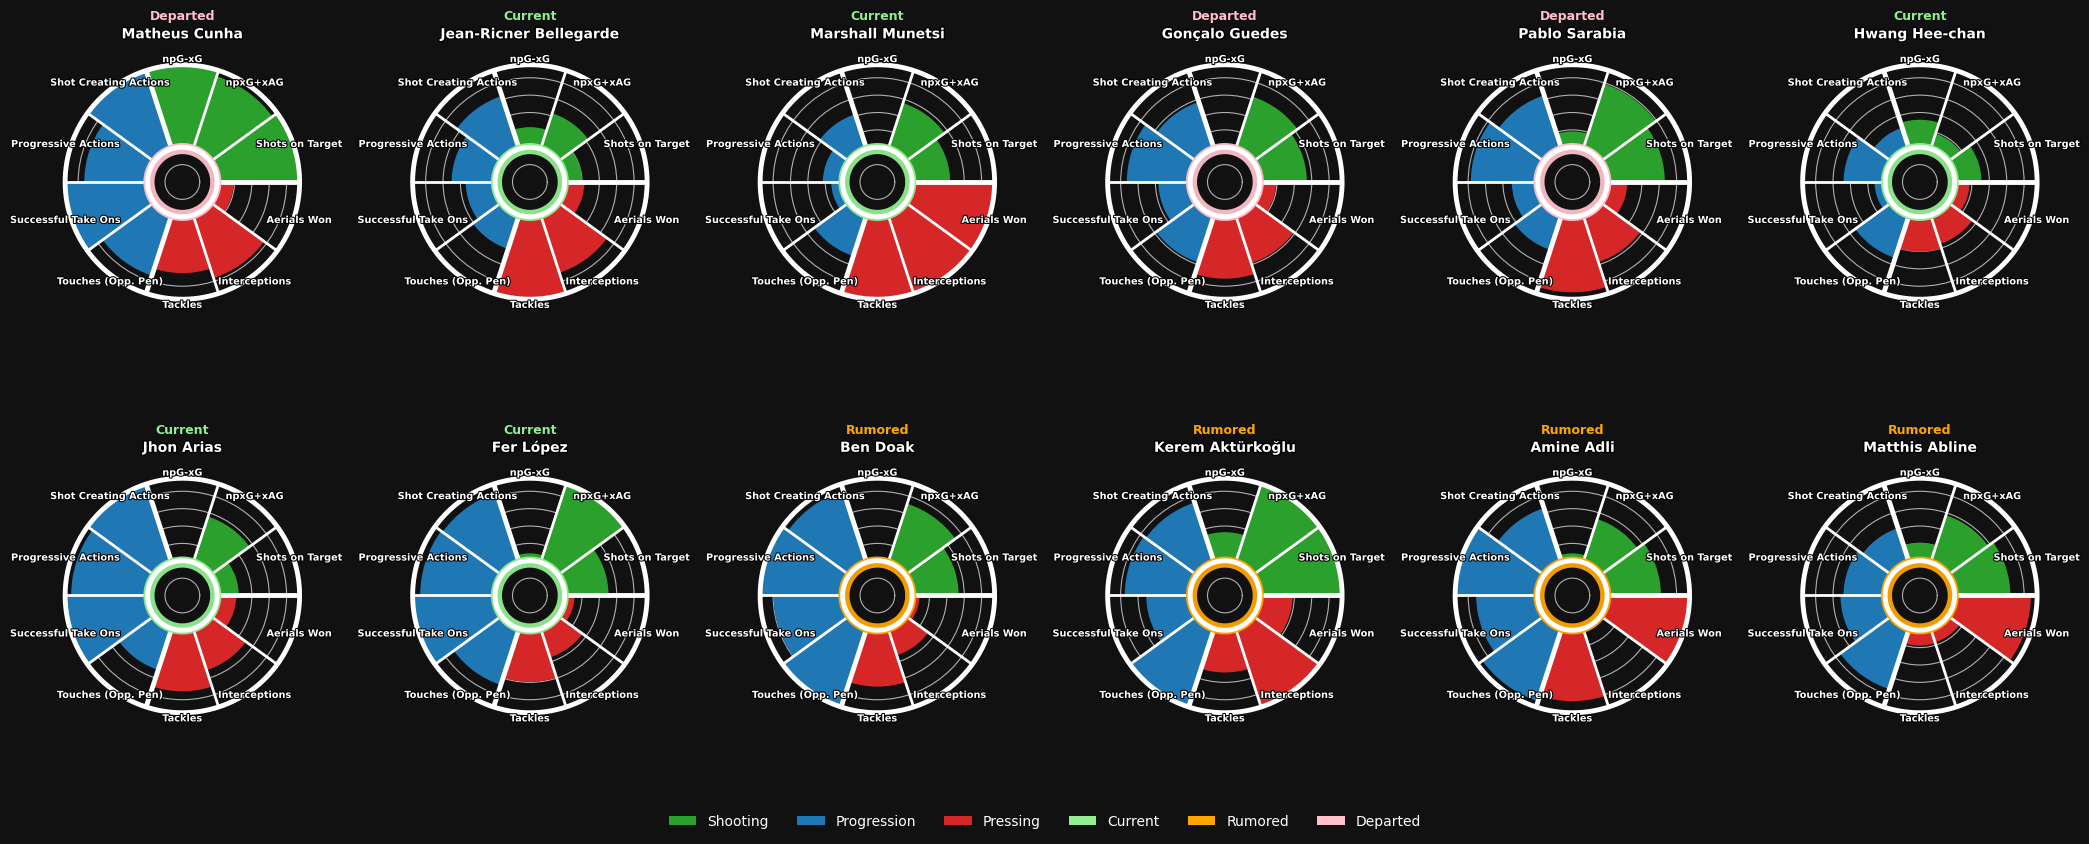

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

FILE = "wolves_standard_stats_scouted.xlsx"
df = pd.read_excel(FILE)

metrics = [
    'SOT90','npxG+xAG90','npG-xG90',
    'SCA90','PrgA90','STO90','TAP90',
    'Tackles90','Int90','AW90'
]
display_names = {
    'SOT90': 'Shots on Target',
    'npxG+xAG90': 'npxG+xAG',
    'npG-xG90': 'npG-xG',
    'SCA90': 'Shot Creating Actions',
    'PrgA90': 'Progressive Actions',
    'STO90': 'Successful Take Ons',
    'TAP90': 'Touches (Opp. Pen)',
    'Tackles90': 'Tackles',
    'Int90': 'Interceptions',
    'AW90': 'Aerials Won'
}

shooting = ['SOT90','npxG+xAG90','npG-xG90']
progress  = ['SCA90','PrgA90','STO90','TAP90']
pressing  = ['Tackles90','Int90','AW90']

SHOOT_COLOR = "#2ca02c"   
PROG_COLOR  = "#1f77b4"   
PRESS_COLOR = "#d62728"  

def color_for_metric(m):
    if m in shooting: return SHOOT_COLOR
    if m in progress: return PROG_COLOR
    return PRESS_COLOR
wedge_colors = [color_for_metric(m) for m in metrics]

FIG_BG = AX_BG = "#111111"
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.5

cam_df = df[df["Position"] == "CAM"].copy()
players = cam_df["Player"].astype(str).tolist()

nonneg_metrics = [m for m in metrics if m != 'npG-xG90']
p90 = df[nonneg_metrics].quantile(0.90).replace(0, np.nan) 

npGx_min_all = df['npG-xG90'].min()
npGx_max_all = df['npG-xG90'].max()
npGx_rng_all = max(1e-9, npGx_max_all - npGx_min_all)

norm_df = cam_df.copy()
for m in nonneg_metrics:
    denom = p90[m] if pd.notna(p90[m]) else 1.0
    norm_df[m] = (cam_df[m] / denom).clip(0.0, 1.0)

norm_df['npG-xG90'] = ((cam_df['npG-xG90'] - npGx_min_all) / npGx_rng_all).clip(0.0, 1.0)

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
width = 2*np.pi / len(metrics)
inner_radius = 0.35
outer_radius = inner_radius + 1.0
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_shoot_end = len(shooting)                  
idx_prog_end  = len(shooting) + len(progress)  

STATUS_COLORS = {"Current": "lightgreen", "Rumored": "orange", "Departed": "pink"}
status_raw = cam_df["Status"].fillna("").astype(str).str.strip().str.lower()

def _status_label(s):
    if s == "left": return "Departed"
    if s == "rumor": return "Rumored"
    return "Current"

status_labels = status_raw.map(_status_label)
status_by_player = dict(zip(cam_df["Player"], status_labels))
status_colors_by_player = {p: STATUS_COLORS[status_by_player[p]] for p in players}

n_players = len(players)
ncols = 6
nrows = int(np.ceil(n_players / ncols))

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, subplot_kw=dict(polar=True),
    figsize=(ncols * 3.5, nrows * 4.5)
)
axs = axs.flatten()

for i, name in enumerate(players):
    vals = norm_df.loc[norm_df['Player'] == name, metrics].values.flatten()

    ax = axs[i]
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, outer_radius)

    inner_circle_radius_overlay = inner_radius + 0.05
    scale = outer_radius - inner_circle_radius_overlay

    ax.bar(
        angles, vals * scale, width=width, bottom=inner_circle_radius_overlay,
        align='edge', color=wedge_colors, zorder=2
    )

    for ang in angles:
        ax.plot([ang, ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, zorder=3, solid_capstyle='butt')

    for b_idx in [0, idx_shoot_end, idx_prog_end]:
        b_ang = angles[b_idx]
        ax.plot([b_ang, b_ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, zorder=4, solid_capstyle='butt')

    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=5, clip_on=False, solid_capstyle='butt')

    for ang, lab in zip(angles + width/2, [display_names[m] for m in metrics]):
        txt = ax.text(
            ang, inner_radius + 1.065, lab,
            rotation=0, ha='center', va='center',
            fontsize=7, fontweight='bold', color='white', zorder=6
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()
        ])

    status_ring_r = inner_radius + 0.035
    ax.plot(theta_circle, np.full_like(theta_circle, status_ring_r),
            color=status_colors_by_player[name], linewidth=8, zorder=9, solid_capstyle='butt', alpha=0.95)

    ax.plot(theta_circle, np.full_like(theta_circle, inner_circle_radius_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=10, clip_on=False, solid_capstyle='butt')

    ax.text(0.5, 1.18, status_by_player[name],
            transform=ax.transAxes, ha='center', va='bottom',
            fontsize=9, fontweight='bold', color=status_colors_by_player[name])
    title_text = ax.text(
        0.5, 1.10, name,
        transform=ax.transAxes, ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

    ax.set_xticks([])
    ax.set_thetagrids([])
    ax.set_yticklabels([])

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

fig.patch.set_facecolor(FIG_BG)

legend_handles = [
    Patch(facecolor=SHOOT_COLOR, label="Shooting"),
    Patch(facecolor=PROG_COLOR,  label="Progression"),
    Patch(facecolor=PRESS_COLOR, label="Pressing"),
    Patch(facecolor=STATUS_COLORS["Current"],  label="Current"),
    Patch(facecolor=STATUS_COLORS["Rumored"],  label="Rumored"),
    Patch(facecolor=STATUS_COLORS["Departed"], label="Departed"),
]
leg = fig.legend(
    handles=legend_handles, loc='lower center', ncol=6,
    bbox_to_anchor=(0.5, 0.02), frameon=True
)
plt.setp(leg.get_texts(), color='white')
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

plt.tight_layout(rect=[0, 0.06, 1, 1], h_pad=3.0)
plt.show()


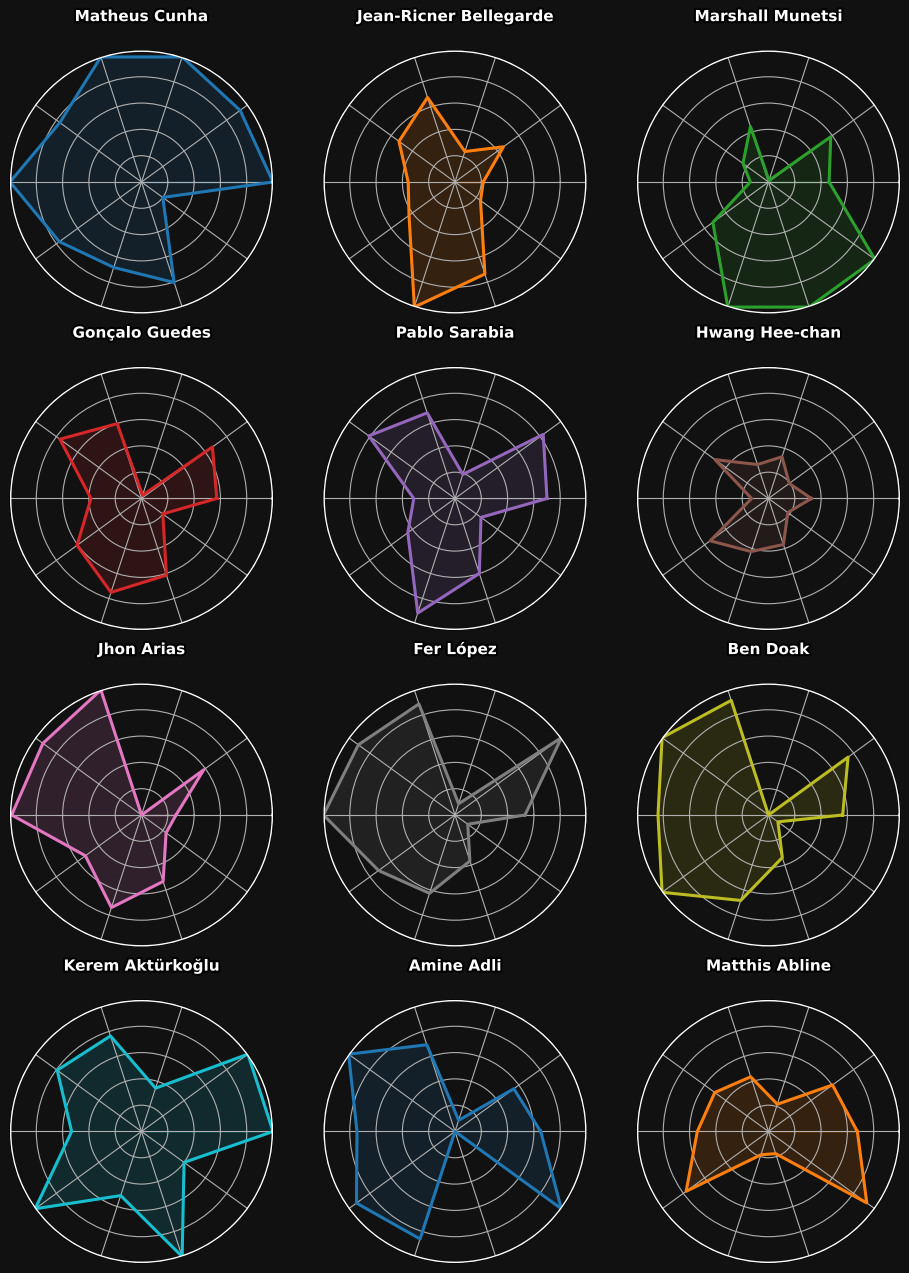

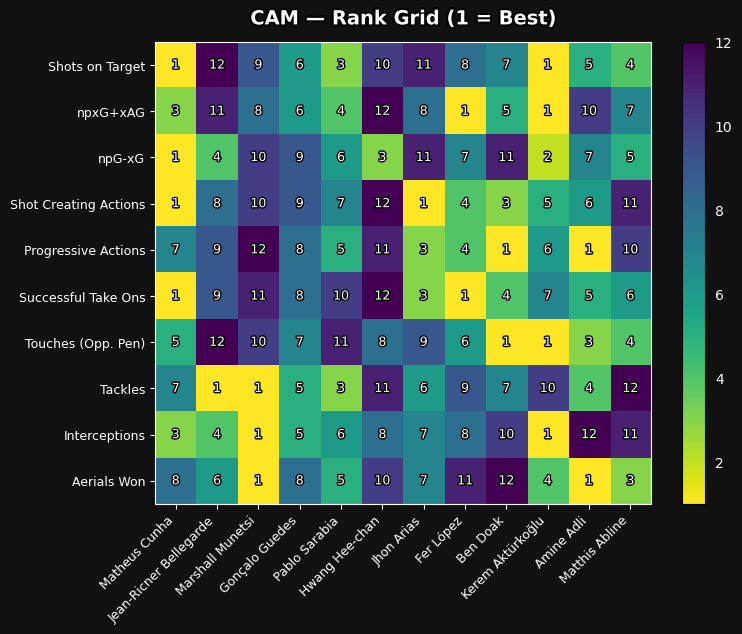

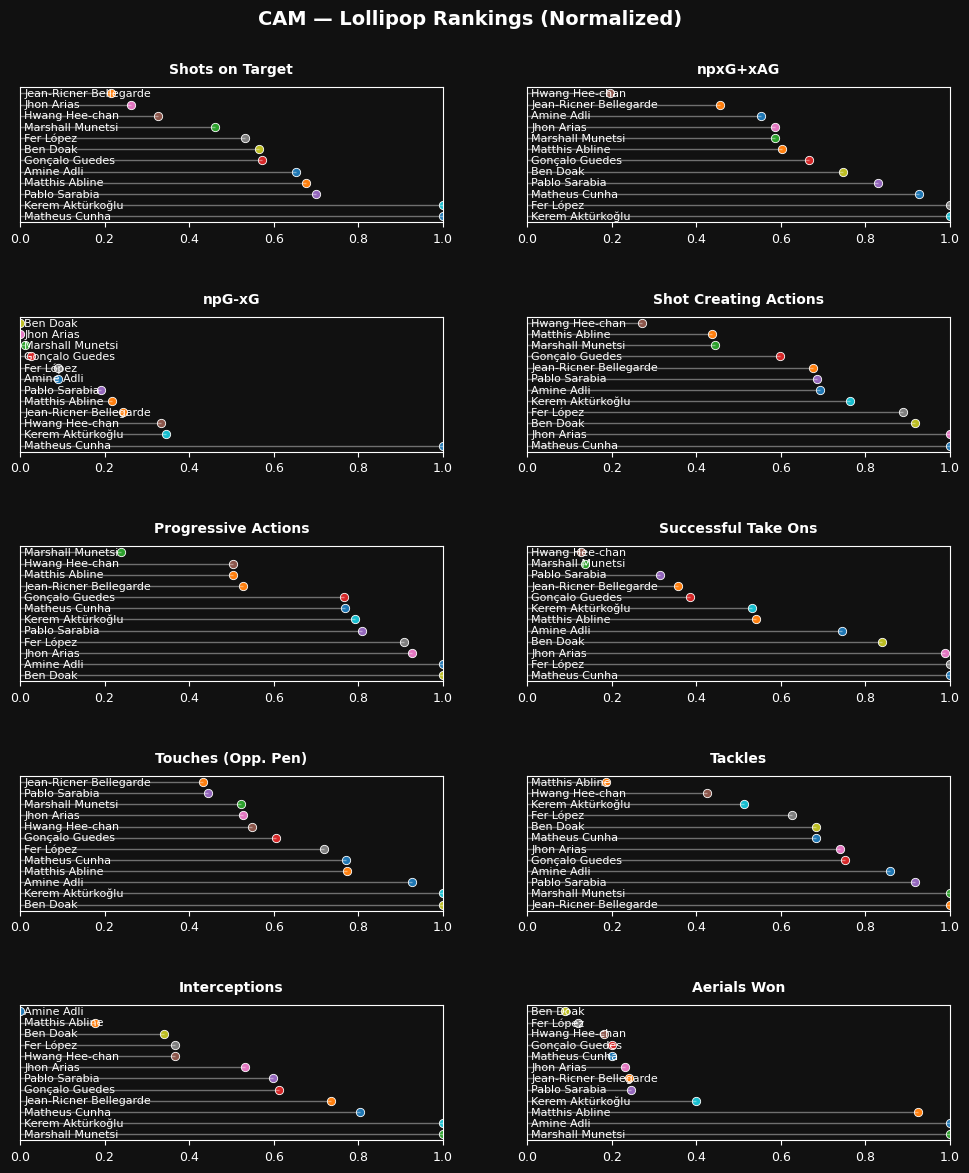

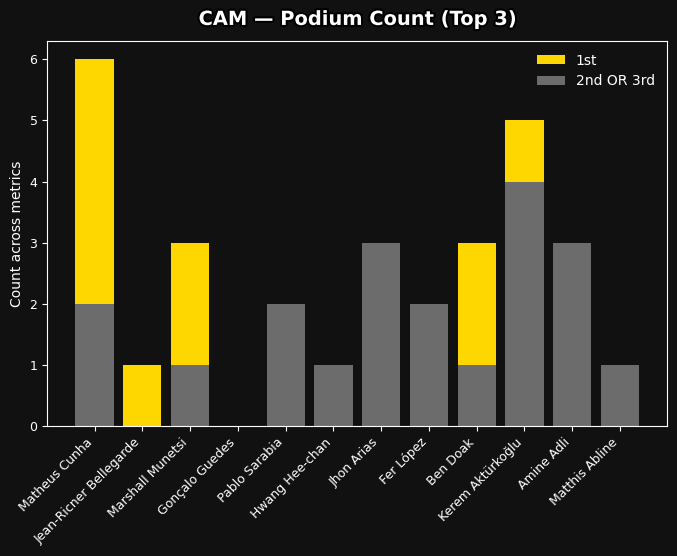

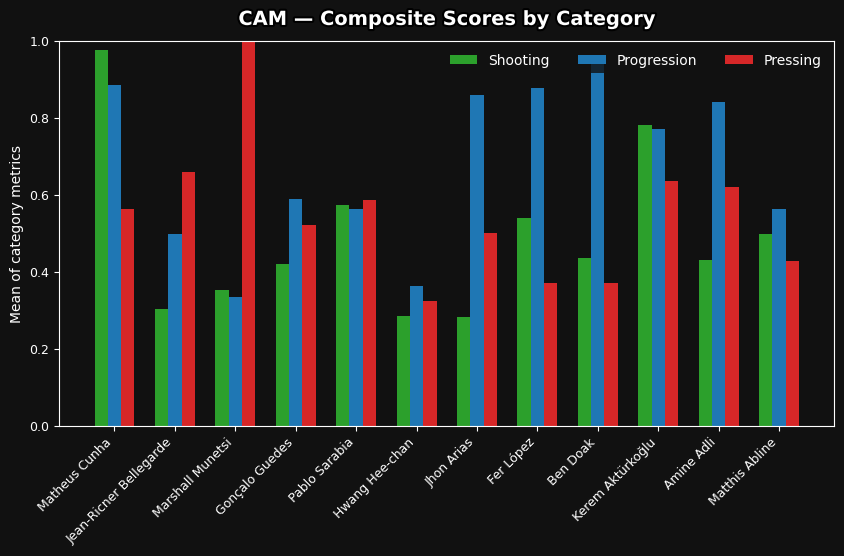

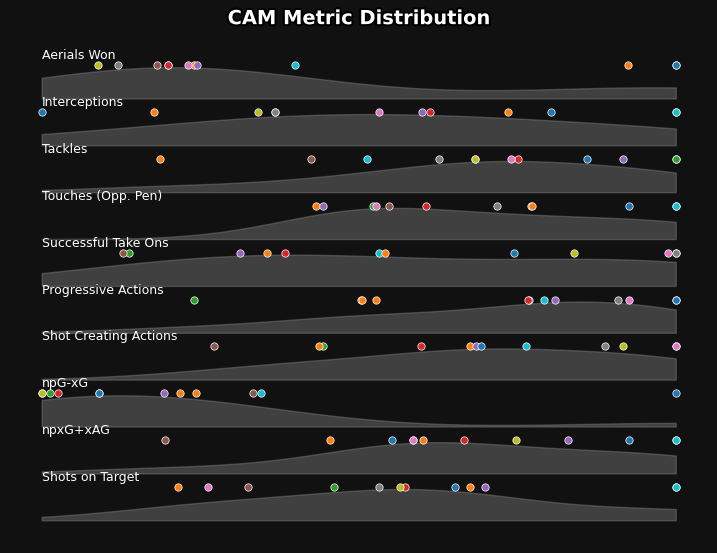

In [ ]:
# IMPORTANT:
# These are generated by chat for more advanced visualization schemes


# =========================
# FULLY-STYLED CAM VIS TOOLKIT
# =========================
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from collections import defaultdict

# ---- expects these to exist from your CAM prep ----
# norm_df (CAM-only, normalized 0–1 with robust npG-xG90)
# metrics, display_names, players
# FIG_BG, AX_BG
# SHOOT_COLOR, PROG_COLOR, PRESS_COLOR

# If you want, define category lists here to be explicit:
shooting  = ['SOT90','npxG+xAG90','npG-xG90']
progress  = ['SCA90','PrgA90','STO90','TAP90']
pressing  = ['Tackles90','Int90','AW90']

# ---------- helpers ----------
def _dark_fig_ax(size=(7,7)):
    fig = plt.figure(figsize=size)
    fig.patch.set_facecolor(FIG_BG)
    ax = plt.subplot(111)
    ax.set_facecolor(AX_BG)
    return fig, ax

def _style_axes(ax):
    ax.tick_params(colors='white', labelsize=9)
    for spine in ax.spines.values():
        spine.set_color('white')

def _title(ax, text, y=1.02, size=14):
    t = ax.set_title(text, color='white', fontsize=size, fontweight='bold', y=y)
    t.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

def _save(fig, name=None, pad=0.3):
    plt.show()
    plt.close(fig)

def _names_for_metrics(mets):
    return [display_names[m] for m in mets]

# Category composites (rows=players)
def _category_composites(M):
    S = M[shooting].mean(axis=1) if set(shooting).issubset(M.columns) else None
    P = M[progress].mean(axis=1) if set(progress).issubset(M.columns) else None
    R = M[pressing].mean(axis=1) if set(pressing).issubset(M.columns) else None
    return S, P, R

# Z-score per column
def _zscore(M):
    return (M - M.mean()) / (M.std(ddof=0).replace(0, 1))

# consistent player color map
player_cmap = {p: plt.cm.tab10(i % 10) for i,p in enumerate(players)}

# Base matrix (players x metrics) using your normalized values
M = norm_df.set_index('Player')[metrics].loc[players]

# ============================================
# 1) Z-score heatmap (players x metrics)
# ============================================
def vis_heatmap_zscore():
    mat = _zscore(M.copy())
    fig, ax = _dark_fig_ax((7,7))
    im = ax.imshow(mat.values, aspect='auto', cmap='coolwarm')
    ax.set_yticks(range(len(players)))
    ax.set_yticklabels(players, color='white', fontsize=9)
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(_names_for_metrics(metrics), rotation=45, ha='right', color='white', fontsize=8)
    _style_axes(ax)
    _title(ax, "CAM — Metric Heatmap (z-score)")
    cbar = fig.colorbar(im)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    _save(fig, "cam_heatmap_zscore.png")

# ============================================
# 2) Beeswarm / strip by metric
# ============================================
def vis_beeswarm():
    fig, ax = _dark_fig_ax((7,7))
    y_positions = np.arange(len(metrics))
    for i, m in enumerate(metrics):
        xs = M[m].values
        y = np.full_like(xs, y_positions[i], dtype=float) + (np.random.rand(len(xs))-0.5) * 0.25
        for x, yy, p in zip(xs, y, players):
            ax.scatter(x, yy, s=36, color=player_cmap[p], edgecolor='white', linewidth=0.6, zorder=2)
    # means
    means = M.mean(axis=0).values
    ax.scatter(means, y_positions, s=80, facecolors='none', edgecolor='white', linewidth=1.4, zorder=3)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(_names_for_metrics(metrics), color='white', fontsize=9)
    ax.set_xlabel("Normalized value (0–1)", color='white')
    _style_axes(ax)
    _title(ax, "CAM — Beeswarm by Metric (w/ means)")
    _save(fig, "cam_beeswarm.png")

# ============================================
# 5) Radar small multiples (grid)
# ============================================
def vis_radar_small_multiples():
    n = len(players)
    cols = 3
    rows = math.ceil(n/cols)
    fig = plt.figure(figsize=(cols*3.2, rows*3.2))
    fig.patch.set_facecolor(FIG_BG)
    angles_p = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    for i, p in enumerate(players, 1):
        ax = plt.subplot(rows, cols, i, polar=True)
        ax.set_facecolor(AX_BG); ax.set_ylim(0,1)
        vals = M.loc[p].values
        ax.plot(np.append(angles_p, angles_p[0]), np.append(vals, vals[0]), color=player_cmap[p], linewidth=2.2)
        ax.fill_between(np.append(angles_p, angles_p[0]), 0, np.append(vals, vals[0]),
                        color=player_cmap[p], alpha=0.15)
        ax.set_xticks(angles_p); ax.set_yticklabels([]); ax.set_xticklabels([])
        # inner/outer rings
        th = np.linspace(0,2*np.pi,720)
        ax.plot(th, np.full(720, 0), color='white', lw=3.5, alpha=1.0, zorder=5)
        ax.plot(th, np.full(720, 1), color='white', lw=2.0, alpha=1.0, zorder=5)
        t = ax.set_title(p, color='white', fontsize=11, y=1.08, fontweight='bold')
        t.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    plt.tight_layout()
    _save(fig, "cam_radar_small_multiples.png", pad=0.2)

# ============================================
# 8) Rank grid (metric x player, numbers)
# ============================================
def vis_rank_grid():
    ranks = M.rank(axis=0, ascending=False).astype(int)
    fig, ax = _dark_fig_ax((8,6))
    im = ax.imshow(ranks.values.T, aspect='auto', cmap='viridis_r')
    ax.set_yticks(range(len(metrics)))
    ax.set_yticklabels(_names_for_metrics(metrics), color='white', fontsize=9)
    ax.set_xticks(range(len(players)))
    ax.set_xticklabels(players, rotation=45, ha='right', color='white', fontsize=8)
    for i in range(len(players)):
        for j in range(len(metrics)):
            val = ranks.values[i, j]
            txt = ax.text(i, j, str(val), ha='center', va='center',
                          color='white', fontsize=9, zorder=3)
            txt.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    _style_axes(ax)
    _title(ax, "CAM — Rank Grid (1 = Best)")
    cbar = fig.colorbar(im)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    _save(fig, "cam_rank_grid.png")

# ============================================
# 9) Lollipop ranks per metric (multi-panel)
# ============================================
def vis_lollipop_ranks():
    r, c = 5, 2
    pages = math.ceil(len(metrics)/(r*c))
    for page in range(pages):
        fig = plt.figure(figsize=(c*6, r*2.6))
        fig.patch.set_facecolor(FIG_BG)
        for k in range(r*c):
            idx = page*(r*c)+k
            if idx >= len(metrics): break
            m = metrics[idx]
            ax = plt.subplot(r, c, k+1)
            ax.set_facecolor(AX_BG)
            s = M.sort_values(by=m, ascending=False)[m]
            ax.hlines(y=np.arange(len(s)), xmin=0, xmax=s.values, color='white', lw=1, alpha=0.4)
            for i,(p,val) in enumerate(s.items()):
                ax.scatter(val, i, s=36, color=player_cmap[p], edgecolor='white', linewidth=0.6)
                ax.text(0.01, i, p, va='center', color='white', fontsize=8)
            ax.set_yticks([])
            ax.set_xlim(0,1)
            ax.set_title(display_names[m], color='white', fontsize=10, fontweight='bold', pad=10)
            _style_axes(ax)
        fig.suptitle("CAM — Lollipop Rankings (Normalized)", y=0.98, color='white', fontsize=14, fontweight='bold')
        plt.subplots_adjust(top=0.92, hspace=0.7)
        _save(fig, f"cam_lollipop_ranks_p{page+1}.png", pad=0.3)

# ============================================
# 10) Medal table (top1/top3 counts)
# ============================================
def vis_medal_table():
    counts_top1 = defaultdict(int)
    counts_top3 = defaultdict(int)
    for m in metrics:
        s = M.sort_values(by=m, ascending=False)[m]
        counts_top1[s.index[0]] += 1
        for p in s.index[:3]: counts_top3[p] += 1
    fig, ax = _dark_fig_ax((8,5))
    x = np.arange(len(players))
    top3_only = np.array([counts_top3[p]-counts_top1[p] for p in players])
    ax.bar(x, [counts_top1[p] for p in players], bottom=top3_only, color="#ffd700", label="1st")
    ax.bar(x, top3_only, color="#aaaaaa", alpha=0.6, label="2nd OR 3rd")
    ax.set_xticks(x); ax.set_xticklabels(players, rotation=45, ha='right', color='white')
    ax.set_ylabel("Count across metrics", color='white')
    _style_axes(ax); _title(ax, "CAM — Podium Count (Top 3)")
    leg = ax.legend(frameon=True)
    for txt in leg.get_texts(): txt.set_color('white')
    leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")
    _save(fig, "cam_medal_table.png")

# ============================================
# 13) Composite score bars (by category)
# ============================================
def vis_composite_bars():
    S, P, R = _category_composites(M)
    fig, ax = _dark_fig_ax((10,5))
    x = np.arange(len(players))
    w = 0.22
    ax.bar(x - w,     S.values, width=w, color=SHOOT_COLOR, label="Shooting")
    ax.bar(x,         P.values, width=w, color=PROG_COLOR,  label="Progression")
    ax.bar(x + w,     R.values, width=w, color=PRESS_COLOR, label="Pressing")
    ax.set_xticks(x); ax.set_xticklabels(players, rotation=45, ha='right', color='white')
    ax.set_ylim(0,1); ax.set_ylabel("Mean of category metrics", color='white')
    _style_axes(ax); _title(ax, "CAM — Composite Scores by Category")
    leg = ax.legend(frameon=True, ncol=3)
    for txt in leg.get_texts(): txt.set_color('white')
    leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")
    _save(fig, "cam_composite_bars.png")

# ============================================
# 18) Metric ridge-like density (approx — small N)
# ============================================
def vis_ridgeline_like():
    try:
        from scipy.stats import gaussian_kde
    except Exception:
        print("scipy not available — skipping ridgeline-like.")
        return
    rows = len(metrics)
    fig, ax = _dark_fig_ax((9, rows*0.45 + 2))
    ax.set_axis_off()
    x = np.linspace(0,1,256)
    base_y = 0
    gap = 1.2
    for i, m in enumerate(metrics):
        vals = M[m].values
        kde = gaussian_kde(vals, bw_method='scott')
        y = kde(x)
        y = y / y.max()
        y = y*0.8
        ax.fill_between(x, base_y, base_y + y, color="#888888", alpha=0.4)
        for v,p in zip(vals, players):
            ax.scatter(v, base_y + 0.85, s=28, color=player_cmap[p], edgecolor='white', linewidth=0.5, zorder=3)
        ax.text(0.0, base_y + 0.95, display_names[m], color='white', fontsize=9, va='bottom')
        base_y += gap
    _title(ax, "CAM Metric Distribution", y=1.02)
    _save(fig, "cam_ridgeline_like.png", pad=0.2)

# =========================
# RUN EVERYTHING (CAM)
# =========================
def run_all_cam_visuals():
    # vis_heatmap_zscore()
    # vis_beeswarm()
    vis_radar_small_multiples()
    vis_rank_grid()
    vis_lollipop_ranks()
    vis_medal_table()
    vis_composite_bars()
    vis_ridgeline_like()

# call this to generate everything:
run_all_cam_visuals()
